# Unsupervised pairwise 3D registration with MONAI

This tutorial shows how to use MONAI to pairwise-register brain MRI images. This is an inter-subject registration. 

The usage of the following features are illustrated in this tutorial:
1. Load Nifti image with metadata
1. Transforms for dictionary format data
1. Build a ["Registration U-Net" (RegUNet)](https://docs.monai.io/en/latest/_modules/monai/networks/nets/regunet.html#RegUNet) that learns to predict dense velocity fields (DVF) from pairs of MRI volumes
1. Integrate the DVF to a dense displacement field (DDF) with the [DVF2DDF block](https://docs.monai.io/en/latest/networks.html#dvf2ddf)
1. Use the predicted DDF to warp an image with [Warp block](https://docs.monai.io/en/latest/networks.html#warp)
1. Compute BendingEnergyLoss 
1. Compute MeanDice metric (Optional, only if groundtruth labels are available for a validation set)


## Setup environment

In [ ]:
'''
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline
'''

## Setup imports

In [1]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os, glob, time
import matplotlib.pyplot as plt
import numpy as np
import shutil
import tempfile
import torch
from torch.nn import MSELoss 
#from monai.apps import download_url, download_and_extract
from monai.config import print_config
from monai.data import DataLoader, Dataset, CacheDataset
from monai.losses import LocalNormalizedCrossCorrelationLoss, BendingEnergyLoss, MultiScaleLoss, DiceLoss
from monai.metrics import DiceMetric
from monai.networks.blocks import Warp, DVF2DDF
from monai.networks.nets import LocalNet, RegUNet
from monai.transforms import (
    AddChanneld,
    Compose,
    LoadImaged,
    RandAffined,
    Resized,
    ScaleIntensityd,
    EnsureTyped,
)
from monai.utils import set_determinism, first

print_config()

MONAI version: 0.6.0
Numpy version: 1.20.2
Pytorch version: 1.9.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0ad9e73639e30f4f1af5a1f4a45da9cb09930179

Optional dependencies:
Pytorch Ignite version: 0.4.5
Nibabel version: 3.2.1
scikit-image version: 0.18.2
Pillow version: 8.2.0
Tensorboard version: 2.5.0
gdown version: 3.13.0
TorchVision version: 0.10.0
ITK version: 5.1.2
tqdm version: 4.61.2
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.2.4
einops version: 0.3.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.
This allows you to save results and reuse downloads.
If not specified a temporary directory will be used.

In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpsqg_oa2n


## Download dataset
Download and extract the dataset

In [3]:
# download data from this URL:
# https://github.com/adalca/medical-datasets/blob/master/neurite-oasis.md
# Direct link should be (last checked: Oct. 2021): https://surfer.nmr.mgh.harvard.edu/ftp/data/neurite/data/neurite-oasis.v1.0.tar
# unzip and set the appropriate path:
pn_neurite = '/home/sahmadi/Projects/MONAI_DeepTemplate/data/neurite-oasis.v1.0'

'resource = "https://zenodo.org/record/3835682/files/training.zip"\n\ncompressed_file = os.path.join(root_dir, "paired_ct_lung.zip")\ndata_dir = os.path.join(root_dir, "paired_ct_lung")\nif not os.path.exists(data_dir):\n    download_and_extract(resource, compressed_file, root_dir)\n    os.rename(os.path.join(root_dir, "training"), data_dir)\n'

## Set dataset path

In [3]:
import random

random.seed(1000)

volume_files = sorted(glob.glob(os.path.join(pn_neurite,'*','aligned_norm.nii.gz')))
volume_files_train = volume_files[:360]
volume_files_val = volume_files[360:380]
volume_files_test = volume_files[380:]

vol_pairs = {}

for key, nr_pairs, vol_files in zip(['train','val','test'],
                                    [100, 20, 20],
                                    [volume_files_train, volume_files_val, volume_files_test]):
    
    list_of_pairs = []
    for idx_fix in range(len(vol_files)):
        for idx_mov in range(len(vol_files)):
            if (idx_mov==idx_fix):
                continue
            list_of_pairs.append({
                               "fixed_image": vol_files[idx_fix],
                               "moving_image": vol_files[idx_mov]
                              })
    random.shuffle(list_of_pairs)
    vol_pairs[key] = list_of_pairs[:nr_pairs]



In [4]:
for key in ['train','val','test']:
    print('Volume pairs in %s set: %d'%(key, len(vol_pairs[key])))

Volume pairs in train set: 100
Volume pairs in val set: 20
Volume pairs in test set: 20


In [14]:
'''
# export 20 volumes for anisotropic MONAI-Label experiments
import shutil
pn_dst = '/home/sahmadi/Projects/MONAI_DeepTemplate/data/neurite_anisotropic'
ffs_dst = []
for idx, volume_file in enumerate(volume_files):
    if idx==20:
        break
    sub_id = volume_file.split('/')[-2]
    ff_dst = os.path.join(pn_dst,f'{sub_id}.nii.gz')
    shutil.copyfile(volume_file, ff_dst)
    ffs_dst.append(ff_dst)
''' 

In [15]:
ffs_dst

['/home/sahmadi/Projects/MONAI_DeepTemplate/data/neurite_anisotropic/OASIS_OAS1_0001_MR1.nii.gz',
 '/home/sahmadi/Projects/MONAI_DeepTemplate/data/neurite_anisotropic/OASIS_OAS1_0002_MR1.nii.gz',
 '/home/sahmadi/Projects/MONAI_DeepTemplate/data/neurite_anisotropic/OASIS_OAS1_0003_MR1.nii.gz',
 '/home/sahmadi/Projects/MONAI_DeepTemplate/data/neurite_anisotropic/OASIS_OAS1_0004_MR1.nii.gz',
 '/home/sahmadi/Projects/MONAI_DeepTemplate/data/neurite_anisotropic/OASIS_OAS1_0005_MR1.nii.gz',
 '/home/sahmadi/Projects/MONAI_DeepTemplate/data/neurite_anisotropic/OASIS_OAS1_0006_MR1.nii.gz',
 '/home/sahmadi/Projects/MONAI_DeepTemplate/data/neurite_anisotropic/OASIS_OAS1_0007_MR1.nii.gz',
 '/home/sahmadi/Projects/MONAI_DeepTemplate/data/neurite_anisotropic/OASIS_OAS1_0009_MR1.nii.gz',
 '/home/sahmadi/Projects/MONAI_DeepTemplate/data/neurite_anisotropic/OASIS_OAS1_0010_MR1.nii.gz',
 '/home/sahmadi/Projects/MONAI_DeepTemplate/data/neurite_anisotropic/OASIS_OAS1_0011_MR1.nii.gz',
 '/home/sahmadi/Proj

## Set deterministic training for reproducibility

In [6]:
set_determinism(seed=0)

## Create a Dataset that spawns random tuples of volumes

In our case, "volumes" are actually filepaths to volumes. The classs `RandomTupleDataset` can also spawn tuples of any other objects contained in the list of `src_data`. The tuples can have any length, and can be generated with or without replacement.

In [7]:
from torch.utils.data import Dataset as _TorchDataset
from typing import IO, TYPE_CHECKING, Any, Callable, Dict, List, Optional, Sequence, Union
import collections.abc
from monai.transforms import Compose, Randomizable, ThreadUnsafe, Transform, apply_transform

class RandomTupleDataset(_TorchDataset):
    """
    A generic dataset with a length property and an optional callable data transform
    when fetching a data sample.
    If passing slicing indices, will return a PyTorch Subset, for example: `data: Subset = dataset[1:4]`,
    for more details, please check: https://pytorch.org/docs/stable/data.html#torch.utils.data.Subset

    For example, typical input data can be a list of dictionaries::

        [{                            {                            {
             'img': 'image1.nii.gz',      'img': 'image2.nii.gz',      'img': 'image3.nii.gz',
             'seg': 'label1.nii.gz',      'seg': 'label2.nii.gz',      'seg': 'label3.nii.gz',
             'extra': 123                 'extra': 456                 'extra': 789
         },                           },                           }]
    """

    def __init__(self, src_data: Sequence, 
                 tuple_keys: Sequence[str], 
                 transform: Optional[Callable] = None, 
                 random_seed: int = 0,
                 nr_tuples: int = 128,
                 with_replacement=False) -> None:
        """
        Args:
            data: input data to load and transform to generate dataset for model.
            transform: a callable data transform on input data.

        """
        self.src_data = src_data
        self.len_src_data = len(src_data)
        self.tuple_keys = tuple_keys
        self.nr_tuple_keys = len(tuple_keys)
        self.random_seed = random_seed
        self.with_replacement = with_replacement
        self.transform = transform
        # create data list, i.e. a list of dicts, where dicts are tuples of elements from src_data
        self.nr_tuples = nr_tuples
        self.len_data = nr_tuples
        self.data = self.generate_random_tuples()
        if False:
            random.seed(random_seed)

    def __len__(self) -> int:
        return self.nr_tuples

    def _transform(self, index: int):
        """
        Fetch single data item from `self.data`. Will get paired up into N-tuples in __getitem__()
        """
        data_i = self.data[index]
        return apply_transform(self.transform, data_i) if self.transform is not None else data_i

    def __getitem__(self, index: Union[int, slice, Sequence[int]]):
        """
        Returns a `Subset` if `index` is a slice or Sequence, a data item otherwise.
        """
        self.update_random_tuples()
        if isinstance(index, slice):
            # dataset[:42]
            start, stop, step = index.indices(len(self))
            indices = range(start, stop, step)
            return Subset(dataset=self, indices=indices)
        if isinstance(index, collections.abc.Sequence):
            # dataset[[1, 3, 4]]
            nr_requested_tuples = len(index)
            return Subset(dataset=self, indices=index)
        return self._transform(index)
    
    def generate_random_tuples(self, nr_requested_tuples=-1):
        if nr_requested_tuples==-1:
            nr_requested_tuples = self.nr_tuples
        pairs = []
        for i in range(nr_requested_tuples):
            if self.with_replacement:
                data_idxs = random.choices(list(range(self.len_src_data)), self.nr_tuple_keys)
            else:
                data_idxs = random.sample(list(range(self.len_src_data)), self.nr_tuple_keys)
            pair = dict()
            for tuple_key_idx, tuple_key in enumerate(self.tuple_keys):
                pair[tuple_key] = self.src_data[data_idxs[tuple_key_idx]]
            pairs.append(pair)
        return pairs
    
    def update_random_tuples(self):
        self.data = self.generate_random_tuples()

## Setup transforms for training and validation
Here we use several transforms to augment the dataset:
1. LoadImaged loads the lung CT images and labels from NIfTI format files.
2. AddChanneld as the original data doesn't have channel dim, add 1 dim to construct "channel first" shape.
3. ScaleIntensityRanged extracts intensity range [-285, 3770] and scales to [0, 1].
4. RandAffined efficiently performs rotate, scale, shear, translate, etc. together based on PyTorch affine transform.
5. Resized resize images to the same size.
6. EnsureTyped converts the numpy array to PyTorch Tensor for further steps.

In [8]:
train_transforms = Compose(
    [
        LoadImaged(
            keys=["fixed_image", "moving_image"]
        ),
        AddChanneld(
            keys=["fixed_image", "moving_image"]
        ),
        ScaleIntensityd(
            keys=["fixed_image", "moving_image"]
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(
            keys=["fixed_image", "moving_image"]
        ),
        AddChanneld(
            keys=["fixed_image", "moving_image"]
        ),
        ScaleIntensityd(
            keys=["fixed_image", "moving_image"]
        ),
    ]
)

## Check transforms in DataLoader
Visulize a single batch to check the transforms.

moving_image shape: torch.Size([192, 160, 224])
fixed_image shape: torch.Size([192, 160, 224])


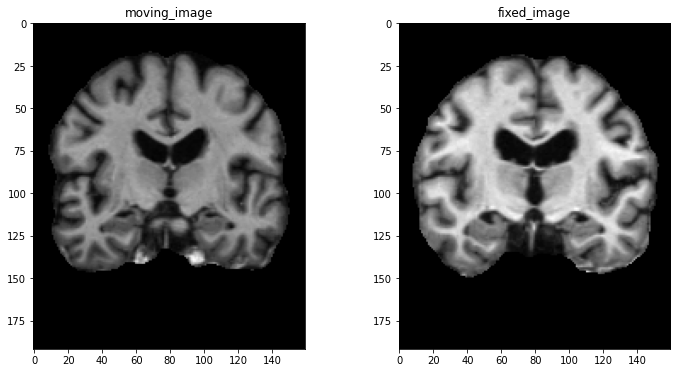

In [9]:
check_ds = RandomTupleDataset(src_data=volume_files_train, 
                              tuple_keys=['fixed_image', 'moving_image'],
                              transform=train_transforms,
                              nr_tuples=128)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
fixed_image = check_data["fixed_image"][0][0].permute(1, 0, 2)
moving_image = check_data["moving_image"][0][0].permute(1, 0, 2)

print(f"moving_image shape: {moving_image.shape}")
print(f"fixed_image shape: {fixed_image.shape}")

# plot the slice [:, :, 112]
slice_idx = 112
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("moving_image")
plt.imshow(moving_image[:, :, slice_idx], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("fixed_image")
plt.imshow(fixed_image[:, :, slice_idx], cmap="gray")

plt.show()
plt.show()

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.
To achieve best performance, set cache_rate=1.0 to cache all the data, if memory is not enough, set lower value.
Users can also set cache_num instead of cache_rate, will use the minimum value of the 2 settings.
And set num_workers to enable multi-threads during caching.
If want to to try the regular Dataset, just change to use the commented code below.


In [36]:
nr_tuples_train = 128
batch_size_train = 1
nr_batches_per_epoch = int(nr_tuples_train / batch_size_train)
train_ds = RandomTupleDataset(src_data=volume_files_train, 
                              tuple_keys=['fixed_image', 'moving_image'],
                              transform=train_transforms,
                              nr_tuples=nr_tuples_train)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=2)

val_ds = CacheDataset(vol_pairs['val'],
                      transform=val_transforms,
                      cache_rate=1.0, 
                      num_workers=2)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=2)

Loading dataset: 100%|██████████| 20/20 [00:02<00:00,  8.99it/s]


#### Create Model, Loss and Optimizer

In [11]:
!nvidia-smi
device = torch.device("cuda:0")
torch.cuda.get_device_name(0)

Wed Sep 22 13:35:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA Quadro R...  On   | 00000000:17:00.0 Off |                  Off |
| 34%   43C    P8    17W / 260W |     10MiB / 24220MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA Quadro R...  On   | 00000000:65:00.0  On |                  Off |
| 33%   

'NVIDIA Quadro RTX 6000'

In [17]:
# standard PyTorch program style: create RegUNet, losses and optimizer
device = torch.device("cuda:0")
model = LocalNet(
    spatial_dims=3,
    in_channels=2,
    out_channels=3,
    num_channel_initial=32,
    extract_levels=[0, 1, 2, 3],
    out_activation=None,
    out_kernel_initializer="zeros").to(device)
dvf2ddf = DVF2DDF()
warp_layer = Warp().to(device)
image_loss = LocalNormalizedCrossCorrelationLoss()
regularization = BendingEnergyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)

Define a forward pass function for ddf computation and warping to avoid duplicate coding.

In [18]:
def forward(batch_data, model):
    fixed_image = batch_data["fixed_image"].to(device)
    moving_image = batch_data["moving_image"].to(device)

    # predict DVF through LocalNet
    dvf = model(torch.cat((moving_image, fixed_image), dim=1))
    #ddf = dvf2ddf(dvf)
    ddf = dvf

    # warp moving image with the predicted ddf
    pred_image = warp_layer(moving_image, ddf)

    return ddf, pred_image

## Execute a typical PyTorch training process
Due to long training time required to for the model to converge, we provide a training snippet that trains for only 5 epochs to illustrate the training process.
Pretrained weight which has been trained for 2000 epochs are provided in the inference section to illustrated the final performance.
If want to train by yourself, simply change max_epochs to 2000.

In [33]:
moving_image.shape

torch.Size([192, 160, 224])

In [30]:
val_ddf.shape

torch.Size([1, 3, 160, 192, 224])

In [ ]:
max_epochs = 500
reset_training_stats = False
if reset_training_stats:
    val_interval = 1
    best_metric = 1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []

for epoch in range(max_epochs):
    time_epoch_start = time.time()
    print("-" * 10)
    if (epoch + 1) % val_interval == 0 or epoch == 0:
        model.eval()
        with torch.no_grad():
            val_losses = []
            for val_data in val_loader:
                # predict ddf
                val_ddf, val_pred_image = forward(val_data, model)
                # compute NLCC loss
                val_fixed_image  = val_data["fixed_image"].to(device)
                val_loss = image_loss(val_fixed_image, val_pred_image) + \
                           10 * regularization(ddf)
                val_losses.append(val_loss.item())

            metric = np.mean(val_losses)
            metric_values.append(metric)
            if metric < best_metric: # our metric is the loss, i.e. monitor DEcreases rather than INcreases
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(),
                           os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f">> current epoch: {epoch + 1} | "
                f"current mean-LNCC-loss: {metric:.4f}\n"
                f">> best mean-LNCC-loss: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    batch_idx = 0
    for batch_data in train_loader:
        time_batch_start = time.time()
        step += 1
        optimizer.zero_grad()

        ddf, pred_image = forward(batch_data, model)

        fixed_image = batch_data["fixed_image"].to(device)
        loss = image_loss(pred_image, fixed_image) + \
               10 * regularization(ddf)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        time_batch_end = time.time()
        batch_idx += 1
        print(f'Mini-batch {batch_idx}/{nr_batches_per_epoch} done (N={batch_data["fixed_image"].shape[0]}). Loss: {loss.item():.8f} (duration: {(time_batch_end-time_batch_start):.2f} sec).')

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    time_epoch_end = time.time()
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f} (duration: {time_epoch_end-time_epoch_start})")

----------
saved new best metric model
>> current epoch: 1 | current mean-LNCC-loss: -0.8064
>> best mean-LNCC-loss: -0.8064 at epoch: 1
epoch 1/500
Mini-batch 1/128 done (N=1). Loss: -0.81424016 (duration: 7.67 sec).
Mini-batch 2/128 done (N=1). Loss: -0.80341697 (duration: 7.73 sec).
Mini-batch 3/128 done (N=1). Loss: -0.79972672 (duration: 7.77 sec).
Mini-batch 4/128 done (N=1). Loss: -0.81443107 (duration: 7.79 sec).
Mini-batch 5/128 done (N=1). Loss: -0.81414878 (duration: 7.82 sec).
Mini-batch 6/128 done (N=1). Loss: -0.80490321 (duration: 7.84 sec).
Mini-batch 7/128 done (N=1). Loss: -0.80463457 (duration: 7.85 sec).
Mini-batch 8/128 done (N=1). Loss: -0.80207276 (duration: 7.86 sec).
Mini-batch 9/128 done (N=1). Loss: -0.81185055 (duration: 7.87 sec).
Mini-batch 10/128 done (N=1). Loss: -0.80917662 (duration: 7.87 sec).
Mini-batch 23/128 done (N=1). Loss: -0.80499119 (duration: 7.90 sec).
Mini-batch 24/128 done (N=1). Loss: -0.79819465 (duration: 7.91 sec).
Mini-batch 25/128 do

In [20]:
print(f"train completed, "
      f"best_metric: {best_metric:.4f}  "
      f"at epoch: {best_metric_epoch}")

train completed, best_metric: -1.0000  at epoch: -1


#### Plot the loss and metric

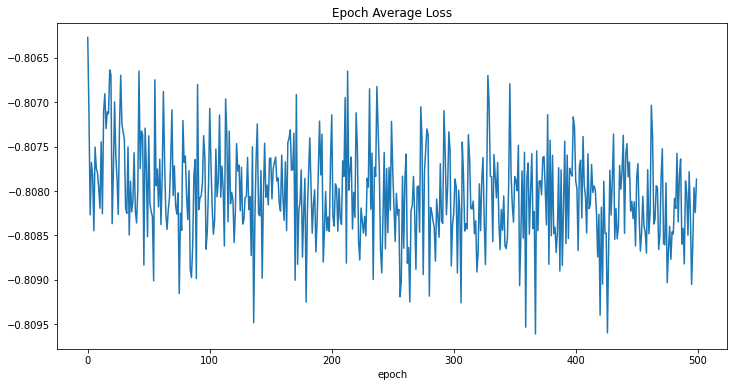

In [52]:
plt.figure("train", (12, 6))
plt.subplot(1, 1, 1)
plt.title("Epoch Average Loss")
x = list(range(len(epoch_loss_values)))
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Inference with the pretrained model

Download and load the pretrained weights.

In [ ]:
'''resource = "https://drive.google.com/uc?id=1SUS8qknkxyF_lRLmjNqMz_DvH3Nygj68"
dst = f"{root_dir}/pretrained_weight.pth"
download_url(resource, dst)
model.load_state_dict(torch.load(dst))
'''

Inference with the pretrained weights and visualise the result at different depth.

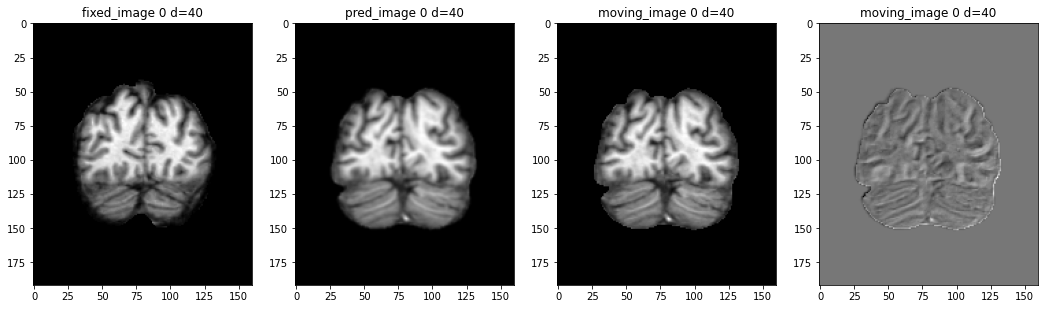

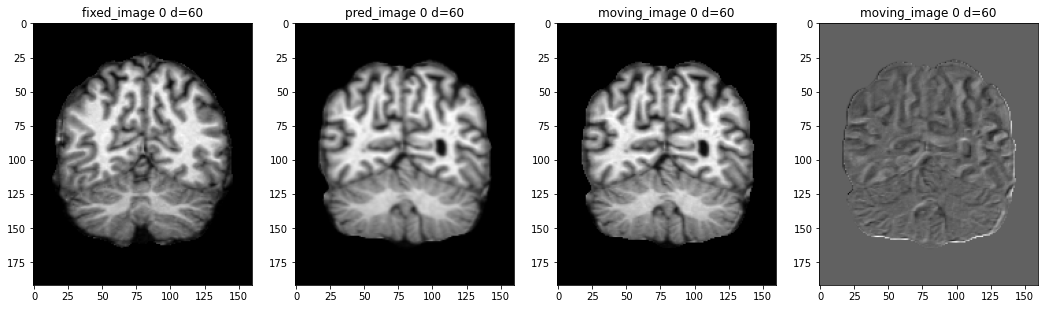

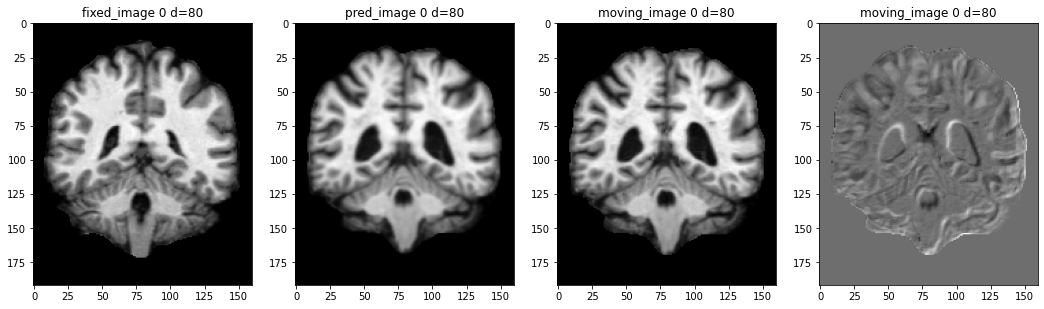

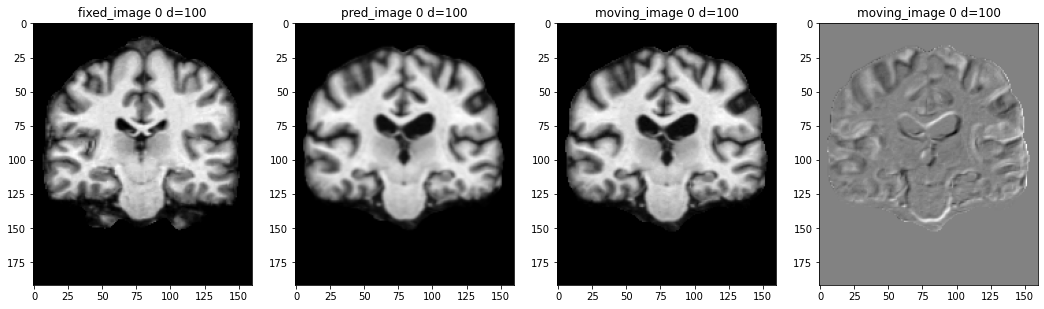

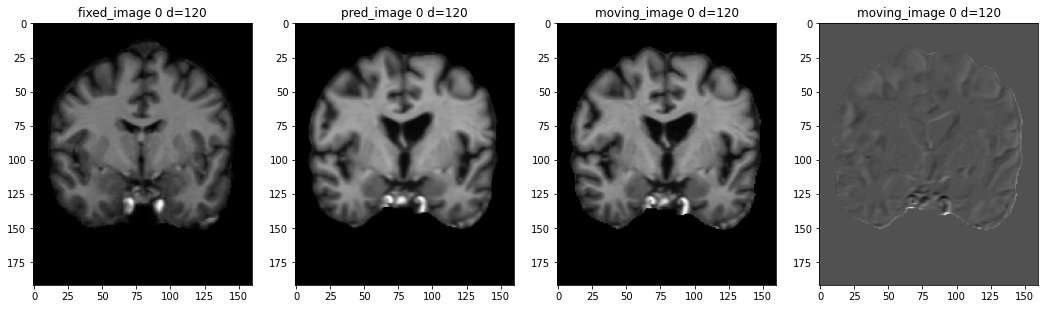

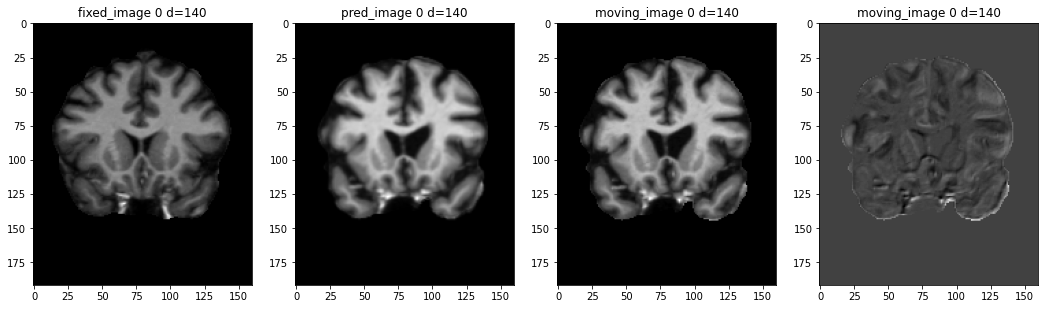

In [55]:
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        if i ==1:
            break
        val_ddf, val_pred_image = forward(val_data, model)
        val_pred_image = val_pred_image.cpu().numpy()[0, 0].transpose((1, 0, 2))
        val_moving_image = val_data["moving_image"].cpu().numpy()[0, 0].transpose((1, 0, 2))
        val_fixed_image = val_data["fixed_image"].cpu().numpy()[0, 0].transpose((1, 0, 2))
        
        for depth in range(40,141,20):
            # plot the slice [:, :, 80]
            plt.figure("check", (18, 6))
            
            plt.subplot(1, 4, 1)
            plt.title(f"fixed_image {i} d={depth}")
            plt.imshow(val_fixed_image[:, :, depth], cmap="gray")
            
            plt.subplot(1, 4, 2)
            plt.title(f"pred_image {i} d={depth}")
            plt.imshow(val_pred_image[:, :, depth], cmap="gray")
                        
            plt.subplot(1, 4, 3)
            plt.title(f"moving_image {i} d={depth}")
            plt.imshow(val_moving_image[:, :, depth], cmap="gray")
            
            plt.subplot(1, 4, 4)
            plt.title(f"moving_image {i} d={depth}")
            plt.imshow(val_moving_image[:, :, depth]-val_pred_image[:, :, depth], cmap="gray")
            
            plt.show()

##Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)